In [18]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../vision_fit'))  # insert parent path
import time
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import scipy
import pickle as pkl
import h5py
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import style
from imagenet_classes import lab_dict
import sklearn
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
style.set_style()
import warnings
warnings.filterwarnings("ignore")

# get data on labs, preds, and feats

In [132]:
out_dir = '/accounts/projects/vision/scratch/yu_dl/raaz.rsk/cnns_preds'
fnames = os.listdir(out_dir)
print(fnames)

['alexnet_feats.h5', 'alexnet.h5', 'top_10_inds_dict.pkl', 'labs.h5', 'vgg19.h5', 'vgg11.h5', 'resnet50.h5', 'resnet18.h5', 'resnet34.h5', 'vgg13.h5', 'densenet169.h5', 'vgg16.h5']


In [88]:
labs_train = h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_train']
labs_val = h5py.File(oj(out_dir, 'labs.h5'), 'r')['labs_val']

In [89]:
preds_train = h5py.File(oj(out_dir, 'alexnet.h5'), 'r')['preds_train']
preds_val = h5py.File(oj(out_dir, 'densenet169.h5'), 'r')['preds_val']

In [90]:
feats_train = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_train']
feats_val = h5py.File(oj(out_dir, 'alexnet_feats.h5'), 'r')['feats_val']

In [91]:
# slightly diff sizes because part of last batch gets cut off for labs

In [92]:
print(labs_train.shape, labs_val.shape, preds_train.shape)
n = labs_train.size

(1281100,) (50000,) (1281150, 1000)


# look at a class

In [93]:
lab_num = 1
print(lab_dict[lab_num])

goldfish, Carassius auratus


In [94]:
print(labs_train.shape, preds_train[:, 0].shape)

(1281100,) (1281150,)


plt.scatter(preds_train[:n, 0], np.array(labs_train)==0)
plt.show()

**for data points in class, does larger pred mean closer to getting it right?**

In [95]:
preds_max_class_val = np.argmax(preds_val, axis=1)

goldfish, Carassius auratus
[115   1   1   1 647   1   1   1   1   1   1 111   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1 396   1   1   1   1   1   1
   1 512 301   1   1  58   1   1   1   1   1   1   1   1]
18.78882 10.507709


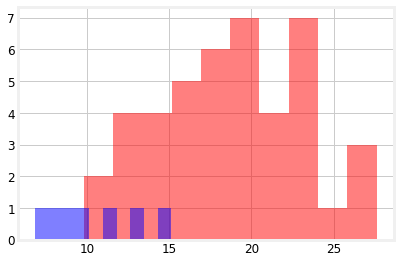

In [99]:
lab_num = 1
print(lab_dict[lab_num])

idxs = np.array(labs_val) == lab_num
preds = preds_val[idxs, lab_num]
preds_max_class = preds_max_class_val[idxs]
print(preds_max_class)
plt.hist(preds[preds_max_class == lab_num], color='red', alpha=0.5)
plt.hist(preds[preds_max_class != lab_num], color='blue', alpha=0.5)

print(np.mean(preds[preds_max_class == lab_num]), np.mean(preds[preds_max_class != lab_num]))
# plt.hist(labs_train, bins=1000)
plt.show()

**hist correct points top pred vs hist wrong points top pred**

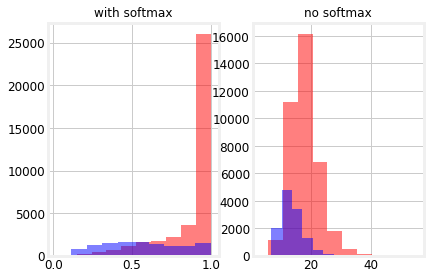

In [100]:
preds_max_val = np.max(scipy.special.softmax(preds_val, axis=1), axis=1)
preds_max_class_v = np.argmax(preds_val, axis=1)
labs = labs_val

plt.subplot(121)
plt.title('with softmax')
plt.hist(preds_max_val[preds_max_class_val == labs_val], color='red', alpha=0.5)
plt.hist(preds_max_val[preds_max_class_val != labs_val], color='blue', alpha=0.5)

plt.subplot(122)
plt.title('no softmax')
preds_max_val = np.max(preds_val, axis=1)
plt.hist(preds_max_val[preds_max_class_val == labs_val], color='red', alpha=0.5)
plt.hist(preds_max_val[preds_max_class_val != labs_val], color='blue', alpha=0.5)
plt.show()

In [19]:
feats_train.shape

(1281150, 4096)

# look at pairwise similarities

In [23]:
from sklearn import metrics

In [ ]:
sims = metrics.pairwise.cosine_similarity(feats_train)
print(sims.shape)

In [ ]:
np.save('sims.npy', sims)

In [26]:
preds_val2 = h5py.File(oj(out_dir, 'densenet169.h5'), 'r')['preds_val']

In [13]:
print(preds_val.shape, preds_val2.shape)

(50000, 1000) (50000, 1000)


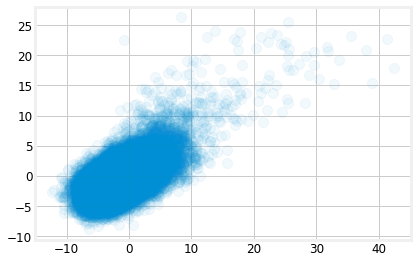

In [17]:
plt.plot(preds_val[:, 0], preds_val2[:, 0], 'o', alpha=0.05)
# plt.plot(scipy.special.softmax(preds_val, axis=1)[:, 0], 
#          scipy.special.softmax(preds_val2, axis=1)[:, 0], 'o', alpha=0.1)
plt.show()

# do different nets put their maxes at the same place?

In [101]:
maxes = []
ind_top10s = [] # these are in ascending order
for fname in tqdm(['alexnet.h5', 'vgg11.h5', 'resnet18.h5', 'densenet169.h5']):
    preds_val = h5py.File(oj(out_dir, fname), 'r')['preds_train']
    maxes.append(np.argmax(preds_val, axis=0))

    # get 10 largest indices for each class
#     ind_top10 = np.argpartition(preds_val, kth=-10, axis=0)[-10:]
    ind_top10 = np.argsort(preds_val, axis=0)[-10:] # in ascending order
    ind_top10s.append(ind_top10)

100%|██████████| 4/4 [15:38<00:00, 235.36s/it]


In [102]:
maxes = np.array(maxes)
ind_top10s = np.array(ind_top10s)

In [104]:
ind_top10s.shape

(4, 10, 1000)

In [106]:
# top_10_inds = {}
# for i, name in enumerate(['alexnet.h5', 'vgg11.h5', 'resnet18.h5', 'densenet169.h5']):
#     top_10_inds[name] = ind_top10s[i]
# pkl.dump(top_10_inds, open(oj(out_dir, "top_10_inds_dict.pkl"), "wb" ))

In [85]:
print(ind_top10s.shape)

(4, 10, 1000)


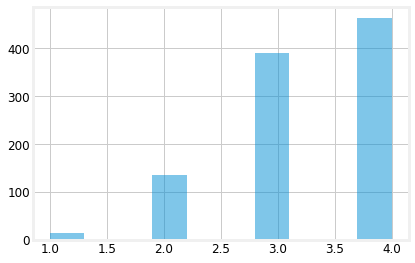

In [82]:
plt.hist(pd.DataFrame(maxes).nunique())
plt.show()

In [72]:
print(np.histogram(pd.DataFrame(maxes[:2]).nunique()))

(array([ 90,   0,   0,   0,   0,   0,   0,   0,   0, 910]), array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]))


In [113]:
maxes.shape
print(maxes[0][:10])
print(top_10_inds['alexnet.h5'][-1, :10])

[  518  2583  2629  5010  5371  7397  8555 10523 10523 11796]
[  518  2583  2629  5010  5371  7397  8555 10523 10523 11796]


In [110]:
top_10_inds.keys()

dict_keys(['alexnet.h5', 'vgg11.h5', 'resnet18.h5', 'densenet169.h5'])

In [117]:
# 2 inputs: k x num_classes 
# output: whether top-1 in first is in top-k of 2nd
# note: this is not symmetric
# note: max is last
def num_agree_topk(inds1, inds2, k=None):
    if k is None:
        k = inds1.shape[0]
    top_inds1 = inds1[-1]
    num_agree = 0
    for class_num in range(inds1.shape[1]):
        if top_inds1[class_num] in inds2[-1 * k:, class_num]:
            num_agree += 1
    return num_agree

num_agree_topk(top_10_inds['alexnet.h5'], top_10_inds['vgg11.h5'])

333

[]


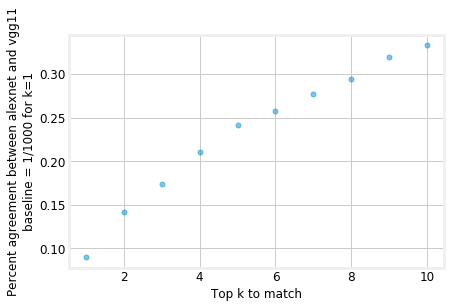

In [137]:
nums_agree = []
nums_agree2 = []
for k in range(1, 11):
    nums_agree.append(num_agree_topk(top_10_inds['alexnet.h5'], top_10_inds['vgg11.h5'], k=k) / 1000)
#     nums_agree2.append(num_agree_topk(top_10_inds['densenet169.h5'], top_10_inds['vgg11.h5'], k=k) / 1000)    
plt.plot(range(1, 11), nums_agree, '.')
# plt.plot(range(1, 11), nums_agree2, '.')
plt.xlabel('Top k to match')
plt.ylabel('Percent agreement between alexnet and vgg11\nbaseline = 1/1000 for k=1')
print(nums_agree2)